In [26]:
from numpy import *
import pandas as pd

# Non-negative Matrix Factorizaion

## 1. using KL divergence as the cost function

In [7]:
def NMF1(dataMat, a, maxCycles, e):
    V = mat(dataMat)
    n, m = shape(V)

    #   initialization
    W = mat(random.random((n, a)))
    H = mat(random.random((a, m)))

    #   multiplicative update rules
    loss = []
    for step in range(maxCycles):
        wh = W * H
        for a in range(a):
            wa_sum = sum(W[:, a])
            for u in range(m):
                wv = multiply(W[:, a], V[:, u])
                b = multiply(wv, 1 / (wh[:, u]))
                H[a, u] *= sum(b) / wa_sum

        for i in range(n):
            wh1 = 1 / (wh[i, :])
            for a in range(a):
                c = multiply(H[a, :], V[i, :])
                d = multiply(c, wh1)
                W[i, a] *= sum(d) / sum(H[a, :])

        #  calculate the loss
        epsilon = 1e-4
        V += epsilon
        wh += epsilon
        err = sum(multiply(V, log(V / wh)) - V + wh)

        loss.append(err)

        if err < e:
            break

    return W, H, loss


In [8]:
V = mat([
    [5, 3, 0, 1],
    [4, 4, 6, 1],
    [1, 1, 0, 5],
    [1, 3, 3, 4],
    [0, 1, 5, 4]]).astype(float64)

In [9]:
if __name__=='__main__':
    W,H,loss = NMF1(V,2,1000,1e-5)
    print(W*H)

[[ 4.2286326   5.6134668   5.63265915  6.71528035]
 [ 3.31443101  2.52722196  3.94551853  3.48713884]
 [ 1.26117481  2.40809357  1.86387907  2.69896227]
 [ 1.80378201  2.88413717  2.52542073  3.3289498 ]
 [ 1.11238588  2.17785957  1.65748683  2.43164244]]


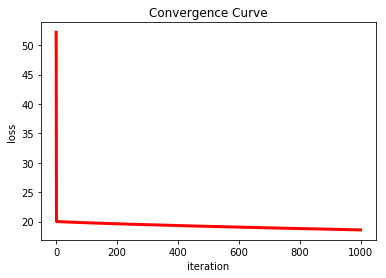

In [10]:
import matplotlib.pyplot as plt
% matplotlib inline

n = len(loss)
plt.plot(range(n), loss, color='r', linewidth=3)
plt.title('Convergence Curve')
plt.xlabel('iteration')
plt.ylabel('loss')

## 2. using Euclidean distance as the cost function

In [11]:
def NMF2(dataMat, a, maxCycles, e):
    V = mat(dataMat)
    n, m = shape(V)

    #   initialization
    W = mat(random.random((n, a)))
    H = mat(random.random((a, m)))
    
    mask = (V > 0).astype(int64)
    
    #   multiplicative update rules 
    loss = []
    
    for step in range(maxCycles):
        wh = W * H 
        
        # update H
        a = W.T * W * H
        a[where(a == 0)] = 1e-4
        H = multiply(H, W.T * V / a)
        
        # update W
        b = wh * H.T
        b[where(b == 0)] = 1e-4
        W = multiply(W, V * H.T / b)

        #  calculate the loss
        err = sum(multiply(V - wh,V - wh))

        loss.append(err)

        if err < e:
            break

    return W, H, loss

In [12]:
if __name__ == '__main__':
    W, H, loss = NMF2(V, 2, 1000, 1e-5)
    print(W * H)

[[  4.13516123e+00   3.06890081e+00   2.07180716e+00   5.89519538e-42]
 [  4.82664781e+00   4.33938728e+00   4.29507252e+00   2.42315969e+00]
 [  3.67407750e-09   1.01646915e+00   2.51910968e+00   3.25242715e+00]
 [  1.41276854e+00   2.26244472e+00   3.71638252e+00   3.88434995e+00]
 [  2.57656535e-01   1.70714100e+00   3.88599189e+00   4.85054087e+00]]


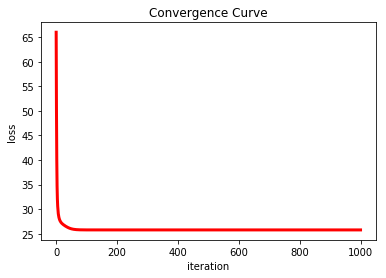

In [14]:
import matplotlib.pyplot as plt
% matplotlib inline

n = len(loss)
plt.plot(range(n), loss, color='r', linewidth=3)
plt.title('Convergence Curve')
plt.xlabel('iteration')
plt.ylabel('loss')


# 3. The application of NMF in moive recommendation

In [27]:
ratings = pd.read_table('/Users/chenxian/Documents/ML_data/ml-100k/u1.base',header=None)

ratings=ratings.iloc[:,0:3]

ratings.columns=['userID','moiveID','rating']

ratings.head()

,userID,moiveID,rating
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3


In [42]:
def user_item_mat(Data):
    #   convert data to the user-item matrix
    
    D = Data
    #   initialize user-item matrix
    user_item_mat = mat(zeros((943, 1682)))

    for i in range(D.shape[0]):
        a = D.iloc[i, 0] - 1
        b = D.iloc[i, 1] - 1
        c = D.iloc[i, 2]
        
        user_item_mat[a, b] = c

    return user_item_mat

In [29]:
if __name__ == '__main__':
    
    # obtain the user-item matrix
    user_item_Mat = user_item_mat(ratings)
    
    W, H, loss = NMF2(user_item_Mat, 100, 1000, 1e-4)
    
    result = W * H

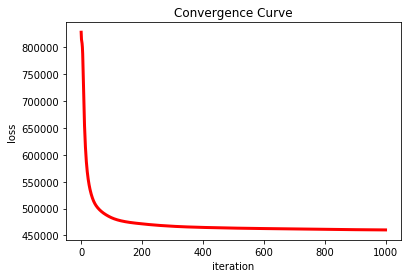

In [31]:
import matplotlib.pyplot as plt
% matplotlib inline

n = len(loss)
plt.plot(range(n), loss, color='r', linewidth=3)
plt.title('Convergence Curve')
plt.xlabel('iteration')
plt.ylabel('loss')


## testing 

In [54]:

ratings_test = pd.read_table('/Users/chenxian/Documents/ML_data/ml-100k/u1.test',header=None)

ratings_test=ratings_test.iloc[:,0:3]

ratings_test.columns=['userID','moiveID','rating']

ratings_test.head()

,userID,moiveID,rating
0,1,6,5
1,1,10,3
2,1,12,5
3,1,14,5
4,1,17,3


In [46]:
uimat_test=user_item_mat(ratings_test)

In [58]:
mse=result[uimat_test>0]-uimat_test[uimat_test>0]
mse=sum(multiply(a,a))
mse=mse/ratings_test.shape[0]
mse

1870071.5475036236

# 4. The application of NMF in the term-document matrix 

In [15]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
data = fetch_20newsgroups(remove = ('headers','footers','quotes')).data

In [16]:
# convert the text to a tf-idf weighted term-document matrix
vectorizer = TfidfVectorizer(max_features=2000, min_df=10, stop_words='english')

X = vectorizer.fit_transform(data)


In [17]:
idx_to_word = array(vectorizer.get_feature_names())

In [18]:
#apply NMF
nmf = NMF(n_components = 20,solver = 'mu')

In [19]:
W = nmf.fit_transform(X)

In [20]:
H = nmf.components_

In [21]:
#weight
W.shape

(11314, 20)

In [22]:
#components
H.shape

(20, 2000)

In [23]:
X.shape

(11314, 2000)

In [24]:
for i, topic in enumerate(H, 1):
    print('Topic{}:{}'.format(i,','.join([str(x) for x in idx_to_word[topic.argsort()[-10:]]])))

Topic1:want,really,say,right,did,good,time,know,don,people
Topic2:information,appreciated,email,help,info,looking,hi,advance,mail,thanks
Topic3:lord,church,christians,christian,believe,faith,christ,bible,jesus,god
Topic4:algorithm,public,escrow,use,government,keys,clipper,encryption,chip,key
Topic5:mac,cd,floppy,controller,ide,hard,disk,drives,scsi,drive
Topic6:15,20,price,condition,offer,shipping,10,new,sale,00
Topic7:use,memory,run,image,screen,running,server,problem,using,program
Topic8:teams,win,hockey,play,players,season,year,games,team,game
Topic9:ftp,article,cc,university,cs,soon,banks,gordon,pitt,edu
Topic10:oil,new,speed,dealer,miles,good,engine,cars,bike,car
Topic11:ram,color,driver,bus,vga,drivers,cards,monitor,video,card
Topic12:exactly,appreciated,doesn,program,work,help,mean,anybody,know,does
Topic13:tell,heard,wanted,oh,thought,ll,wondering,got,ve,just
Topic14:files,version,driver,os,nt,microsoft,drivers,ms,dos,windows
Topic15:convert,disk,pub,gif,format,zip,directory,ft